In [1]:
# Parameters. Set defaults here.
# Times Square replaces this cell with the user's parameters.
record_limit = '999'

<a class="anchor" id="imports"></a>
## Imports and General Setup

In [20]:
# Only use packages available in the Rubin Science Platform
import requests
from collections import defaultdict
import pandas as pd
from pprint import pp, pformat
from urllib.parse import urlencode
from IPython.display import FileLink, display_markdown
from matplotlib import pyplot as plt

In [3]:
env = 'usdf_dev'  # usdf-dev, tucson, slac, summit
log_name = 'narrativelog'
log = log_name
limit = int(record_limit)
response_timeout = 3.05  # seconds, how long to wait for connection
read_timeout = 20  # seconds

timeout = (float(response_timeout), float(read_timeout))

# Env list comes from drop-down menu top of:
# https://rsp.lsst.io/v/usdfdev/guides/times-square/
envs = dict(
    #rubin_usdf_dev = '',
    #data_lsst_cloud = '',
    #usdf = '',
    #base_data_facility = '',
    summit = 'https://summit-lsp.lsst.codes',
    usdf_dev = 'https://usdf-rsp-dev.slac.stanford.edu',
    #rubin_idf_int = '',
    tucson = 'https://tucson-teststand.lsst.codes',
)
server = envs[env]
service = f'{server}/{log}'
service

'https://usdf-rsp-dev.slac.stanford.edu/narrativelog'

<a class="anchor" id="setup_source"></a>
## Setup Source

In [4]:
md = f'### Will retrieve from {service}'
display_markdown(md, raw=True)

### Will retrieve from https://usdf-rsp-dev.slac.stanford.edu/narrativelog

In [5]:
recs = None
ok = True

# is_human=either&is_valid=either&offset=0&limit=50' 
# site_ids=tucson&message_text=wubba&min_level=0&max_level=999&user_ids=spothier&user_agents=LOVE
# tags=love&exclude_tags=ignore_message
qparams = dict(is_human='either',
               is_valid='either',
               limit=limit,
              )
qstr = urlencode(qparams)
url = f'{service}/messages?{qstr}'

ignore_fields = set(['tags', 'urls', 'message_text', 'id', 'date_added', 
                     'obs_id', 'day_obs', 'seq_num', 'parent_id', 'user_id',
                     'date_invalidated', 'date_begin', 'date_end',
                     'time_lost', # float
                     #'systems','subsystems','cscs',  # values are lists, special handling
                    ])

In [6]:
display_markdown(f'## Get (up to {limit}) Records', raw=True)

## Get (up to 999) Records

In [38]:
# TODO Often fails on first request.  Find out why!
try:
    response = requests.get(url, timeout=timeout)
except:
    pass 
    
try:
    print(f'Attempt to get logs from {url=}')
    response = requests.get(url, timeout=timeout)
    response.raise_for_status()
    recs = response.json()
    flds = set(recs[0].keys())
    facflds = flds - ignore_fields
    # facets(field) = set(value-1, value-2, ...)
    facets = {fld: set([str(r[fld])
                for r in recs if not isinstance(r[fld], list)]) 
                    for fld in facflds}
except Exception as err:
    ok = False
    print(f'ERROR getting {log} from {env=} using {url=}: {err=}')
numf = len(flds) if ok else 0
numr = len(recs) if ok else 0
print(f'Retrieved {numr} records, each with {numf} fields.')

Attempt to get logs from url='https://usdf-rsp-dev.slac.stanford.edu/narrativelog/messages?is_human=either&is_valid=either&limit=999'
Retrieved 999 records, each with 24 fields.


<a class="anchor" id="table"></a>
## Tables of (mostly raw) results

### Fields names provided in records from log.

In [8]:
pd.DataFrame(flds, columns=['Field Name'])

,Field Name
0,cscs
1,user_id
2,time_lost
3,primary_software_components
4,site_id
5,category
6,date_added
7,level
8,user_agent
9,systems


### Facets from log records.
A *facet* is the set all of values found for a field in the retrieved records. Facets are only calculated for some fields.

In [37]:
display(pd.DataFrame.from_dict(facets, orient='index'))
display(facets)

,0,1
cscs,None,None
is_human,True,None
time_lost_type,None,fault
level,0,100
user_agent,LOVE,None
systems,None,None
is_valid,True,False
components,None,None
primary_hardware_components,None,None
primary_software_components,None,None


{'cscs': {'None'},
 'is_human': {'True'},
 'time_lost_type': {'None', 'fault'},
 'level': {'0', '100'},
 'user_agent': {'LOVE'},
 'systems': {'None'},
 'is_valid': {'False', 'True'},
 'components': {'None'},
 'primary_hardware_components': {'None'},
 'primary_software_components': {'None'},
 'site_id': {'summit'},
 'subsystems': {'None'},
 'category': {'None', 'SCIENCE'}}

### Table of selected log record fields.
Table can be retrieved as CSV file for local use.

In [10]:
cols = ['date_added', 'time_lost']
df = pd.DataFrame(recs)[cols]

# Allow download of CSV version of DataFrame
csvfile = 'tl.csv'
df.to_csv(csvfile)
myfile = FileLink(csvfile)
print('Table available as CSV file: ')
display(myfile)
df

Table available as CSV file: 


/home/pothiers/sandbox/ts_logging_and_reporting/notebooks_tsqr/tl.csv

,date_added,time_lost
0,2024-03-20T04:16:06.976595,0.0
1,2024-04-24T20:54:19.346646,0.0
2,2024-06-19T01:59:58.701343,0.0
3,2024-08-21T04:22:26.232653,0.0
4,2023-11-21T19:55:36.787105,0.0
...,...,...
994,2024-03-13T04:54:25.129111,0.0
995,2023-12-27T23:02:35.381334,0.0
996,2024-03-04T22:41:03.543119,0.0
997,2024-05-27T23:17:00.061245,0.0


In [11]:
df = pd.DataFrame(recs)
df

,id,site_id,message_text,level,tags,urls,time_lost,date_begin,user_id,user_agent,...,parent_id,systems,subsystems,cscs,date_end,components,primary_software_components,primary_hardware_components,category,time_lost_type
0,0005d0e0-6de7-4857-b658-cfca7147374a,summit,The moveShutterMainDoor command Fail\r\n\r\n\r...,0,[],[],0.0,2024-03-20T04:15:26.769000,cmorales@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-03-20T04:15:26.769000,[AuxTel],[None],[None],None,fault
1,00067b6a-1741-41f3-87af-57261dff30ac,summit,David updated environment. But no need to cycl...,0,[],[],0.0,2024-04-24T20:53:41.843000,ykang@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-04-24T20:53:41.843000,[MainTel],[None],[None],None,fault
2,000a3ba8-b1a9-4b04-9c4a-263da3dac1d1,summit,"Runing BLOCK-T22 AuxTel filter Scans, the auxt...",0,[],[],0.0,2024-06-19T01:59:08.706000,cmd_user@summit-lsp.lsst.codes,LOVE,...,af0157e3-d7f0-4068-9a8a-e51a0a77d260,None,None,None,2024-06-19T01:59:08.706000,[AuxTel],[None],[None],None,fault
3,0010e246-8039-4741-b4c6-54047e9464c5,summit,Still checking updates in the wavefront estima...,0,[],[],0.0,2024-08-21T04:04:38.053000,kpena@summit-lsp.lsst.codes,LOVE,...,99de2a12-20eb-45ae-b189-a793b63e6ab5,None,None,None,2024-08-21T04:04:38.053000,[AuxTel],[None],[None],None,fault
4,0017b90e-26aa-4a7c-8186-fc06ac9b5aa6,summit,The m1m3 ump test failed for actuator 108. \r\...,0,[],[],0.0,2023-11-21T19:51:54.868000,bquint@love01.cp.lsst.org,LOVE,...,None,None,None,None,2023-11-21T19:51:54.868000,[MainTel],[None],[None],None,fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,21dfca3e-1ed9-4b3d-b8af-0af7cc20bba5,summit,Run [BLOCK-218|https://jira.lsstcorp.org/brows...,0,[],[],0.0,2024-03-13T04:51:31.209000,ykang@love01.cp.lsst.org,LOVE,...,d10bbbf9-4255-42f0-bab1-0267f8d0d009,None,None,None,2024-03-13T04:51:31.209000,[MainTel],[None],[None],None,fault
995,21e07833-b8d5-47f2-9723-c4c8e860607c,summit,"Preparing Block-175 - staging TMA at az=0, el=...",0,[],[],0.0,2023-12-27T21:12:33.991000,echristensen@love02.cp.lsst.org,LOVE,...,None,None,None,None,2023-12-27T21:12:33.991000,[MainTel],[None],[None],None,fault
996,21e74884-fd34-4538-85da-2c47305855d0,summit,Testing create ticket comment from LOVE K8S Su...,0,[],[https://rubinobs.atlassian.net/browse/OBS-454],0.0,2024-03-04T22:40:24.642000,saranda@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-03-04T22:40:24.642000,None,[None],[None],None,fault
997,21e7c640-6163-4358-90fc-a29352c940c3,summit,Enabling the scheduler again to pull in change...,0,[],[],0.0,2024-05-27T23:16:22.284000,kkelkar@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-05-27T23:16:22.284000,[AuxTel],[None],[None],None,fault


<a class="anchor" id="plot"></a>
## Plots from log

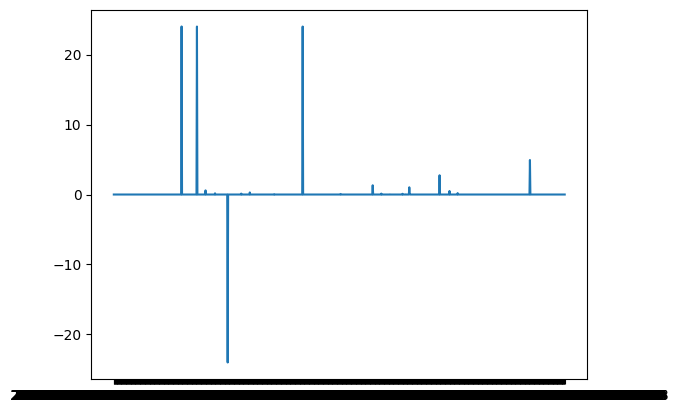

In [12]:
x = [r['date_added'] for r in recs]
y = [r['time_lost'] for r in recs]
plt.plot(x, y) 
plt.show()

<a class="anchor" id="raw_analysis"></a>
## Raw Content Analysis

### Example of one record

In [34]:
display(recs[-1])

{'id': '21ebee65-b30b-4620-ac1c-a2235d27f907',
 'site_id': 'summit',
 'message_text': "OSS didn't turned on, we got a timeout.\r\n",
 'level': 0,
 'tags': [],
 'urls': [],
 'time_lost': 0.0,
 'date_begin': '2024-01-10T20:53:36.828000',
 'user_id': 'jseron@love01.cp.lsst.org',
 'user_agent': 'LOVE',
 'is_human': True,
 'is_valid': True,
 'date_added': '2024-01-10T20:54:21.685248',
 'date_invalidated': None,
 'parent_id': None,
 'systems': None,
 'subsystems': None,
 'cscs': None,
 'date_end': '2024-01-10T20:53:36.828000',
 'components': ['MainTel'],
 'primary_software_components': ['None'],
 'primary_hardware_components': ['None'],
 'category': 'None',
 'time_lost_type': 'fault'}

In [35]:
msg = rec["message_text"]
md = f'Message text from log:\n> {msg}'
display_markdown(md, raw=True)

Message text from log:
> OSS didn't turned on, we got a timeout.


<a class="anchor" id="elicitation"></a>
## Stakeholder Elicitation